# ClearML Exploration and Testing

## Datasets

Import PBP Data:

In [1]:
import nfl_data_py as nfl
from clearml import Task, Dataset

import_pbp_task = Task.init(project_name="NFL WP Model", task_name="Import PBP Data", tags=["NFL", "Play-by-Play", "Data"])

parameters = {
    "start_year": 1999,
    "end_year": 2023
}

import_pbp_task.connect(parameters)
years = list(range(parameters['start_year'], parameters['end_year'] + 1, 1))

pbp_data = nfl.import_pbp_data(years=years, thread_requests=True)
pbp_data = nfl.clean_nfl_data(pbp_data)
pbp_csv_path = f'pbp_data_{parameters["start_year"]}_{parameters["end_year"]}.csv'
pbp_data.to_csv(pbp_csv_path)

pbp_data_desc = f"NFL Play-by-Play Data from {parameters['start_year']}-{parameters['end_year']}"

pbp_dataset = Dataset.create(
    dataset_name="NFL Play-by-Play Data",
    dataset_project="NFL WP Model",
    dataset_tags=["NFL", "Play-by-Play", "Data"],
    description=pbp_data_desc,
    dataset_version="0.2.0"
)

pbp_dataset.add_files(pbp_csv_path)
pbp_dataset.upload()
pbp_dataset.finalize()

import_pbp_task.mark_completed()

ClearML Task: created new task id=b604dfb293904356a9375875971c78bb
ClearML results page: https://app.clear.ml/projects/45d7d44041a2402ca144d9b4786f8dc4/experiments/b604dfb293904356a9375875971c78bb/output/log
2023-11-30 13:42:41,451 - clearml.Task - INFO - Storing jupyter notebook directly as code
Downcasting floats.
ClearML results page: https://app.clear.ml/projects/07c193c570a74ec5b323c1940bf9fc08/experiments/972ea022f3204866b432459ff6c0a524/output/log
ClearML dataset page: https://app.clear.ml/datasets/simple/07c193c570a74ec5b323c1940bf9fc08/experiments/972ea022f3204866b432459ff6c0a524
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start
Uploading dataset changes (1 files compressed to 316.49 MiB) to https://files.clear.ml
File compression and upload completed: total size 316.49 MiB, 1 chunk(s) stored (average size 316.49 MiB)


In [2]:
from multiprocessing import Pool

# Function to save a DataFrame to CSV
def save_to_csv(df_tuple):
    season, df = df_tuple
    filename = f'pbp_data_{season}.csv'
    df.to_csv(filename)
    print(f'Saved {filename}')

# Function to split the DataFrame by season and process in parallel
def process_dataframe(dataframe):
    # Splitting the dataframe by 'season' column
    grouped = dataframe.groupby('season')

    # Creating tuples of (season, dataframe)
    df_tuples = [(season, group) for season, group in grouped]

    # Parallel processing
    with Pool() as pool:
        pool.map(save_to_csv, df_tuples)

In [3]:
import nfl_data_py as nfl

parameters = {
    "start_year": 1999,
    "end_year": 2023
}

years = list(range(parameters['start_year'], parameters['end_year'] + 1, 1))


pbp_data = nfl.import_pbp_data(years=years, thread_requests=True)

Downcasting floats.


In [4]:
process_dataframe(pbp_data)

Saved season_2000.csv
Saved season_1999.csv
Saved season_2001.csv
Saved season_2002.csv
Saved season_2004.csv
Saved season_2005.csv
Saved season_2003.csv
Saved season_2006.csv
Saved season_2008.csv
Saved season_2007.csv
Saved season_2009.csv
Saved season_2010.csv
Saved season_2011.csv
Saved season_2012.csv
Saved season_2013.csv
Saved season_2014.csv
Saved season_2023.csv
Saved season_2015.csv
Saved season_2016.csv
Saved season_2017.csv
Saved season_2018.csv
Saved season_2019.csv
Saved season_2020.csv
Saved season_2021.csv
Saved season_2022.csv


Generate Calibration Data:

In [2]:
from src.preprocessing.preprocessing import WinProbabilityCalibrationData

cal_data_task = Task.init(
    project_name="NFL WP Model", 
    task_name="Generate Calibration Data", 
    tags=["NFL", "Play-by-Play", "Data", "Calibration"]
)
cal_data = pbp_data.copy()

wp_cal = WinProbabilityCalibrationData(1999, 2023)
cal_data = wp_cal.preprocess_data(cal_data)
cal_data = wp_cal.drop_irrelevant_columns(cal_data)
cal_data.head()

cal_data_task.mark_completed()

,half_seconds_remaining,game_seconds_remaining,score_differential,down,ydstogo,yardline_100,posteam_timeouts_remaining,defteam_timeouts_remaining,home,receive_2h_ko,spread_time,diff_time_ratio
0,1800.0,3600.0,NaN,NaN,0.0,30.0,3.0,3.0,1,0,-3.0,NaN
1,1800.0,3600.0,0.0,1.0,10.0,77.0,3.0,3.0,1,0,-3.0,0.0
2,1800.0,3600.0,0.0,2.0,10.0,77.0,3.0,3.0,1,0,-3.0,0.0
3,1800.0,3600.0,0.0,3.0,9.0,76.0,3.0,3.0,1,0,-3.0,0.0
4,1800.0,3600.0,0.0,3.0,14.0,81.0,3.0,3.0,1,0,-3.0,0.0


In [5]:
cal_data.iloc[0]['season']

NameError: name 'cal_data' is not defined

In [3]:
cal_data.to_csv('cal_data_1999_2023.csv')

In [5]:
from clearml import Dataset


cal_dataset = Dataset.create(
    dataset_name="Vegas WP Calibration Data",
    dataset_project="NFL WP Model",
    dataset_tags=["NFL", "Play-by-Play", "Data", "Vegas", "Win-Probability", "Calibration"],
    description="NFL Vegas WP Model Calibration Data from 1999-2023",
    dataset_version="0.1.0"
)

cal_dataset.add_files('cal_data_1999_2023.csv')
cal_dataset.upload()
cal_dataset.finalize()

ClearML results page: https://app.clear.ml/projects/5d88ea3dd2654ddb88e28c4d92a10865/experiments/28c0bcc6a5c44f0c979a236abef60a30/output/log
ClearML dataset page: https://app.clear.ml/datasets/simple/5d88ea3dd2654ddb88e28c4d92a10865/experiments/28c0bcc6a5c44f0c979a236abef60a30
Uploading dataset changes (1 files compressed to 22.45 MiB) to https://files.clear.ml
File compression and upload completed: total size 22.45 MiB, 1 chunk(s) stored (average size 22.45 MiB)


True

In [7]:
from clearml import Task, OutputModel

task = Task.init(project_name="NFL WP Model", task_name="WP Vegas Model")
task.setup_aws_upload(bucket='test', host='minio-test-s3.internal.magiccityit.com:443', key='IJOxeQlvKPgSA84Eq5zr', secret='21fmw0PZuTd35fXqE3YgwSssSqEJMcbBwDgNNWzy', region='us-east-1', verify=True, secure=True)
output_model = OutputModel(task=task)
output_model.set_upload_destination("minio-test-s3.internal.magiccityit.com:443/test")

2023-11-29 17:00:02,299 - clearml.Task - WARNING - Overriding existing configuration for 's3://minio-test-s3.internal.magiccityit.com:443/test'


In [2]:
from src.nfl_data_models.wp_model import WPModel
from sklearn.model_selection import GroupKFold

wp_model = WPModel()
wp_model.wp_spread_calibration_data_path = '../../calibration_data/wp_model_calibration_data.csv'
cal_data = wp_model.import_calibration_data()
X = cal_data.loc[:, ~cal_data.columns.isin(['season', 'game_id', 'label', 'home_team', 'away_team'])]
y = cal_data['label']
groups = cal_data['game_id']

group_fold = GroupKFold(n_splits=5)
for train_index, test_index in group_fold.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

clf = wp_model.train(X_train, y_train, X_test, y_test)
scores = clf.evals_result()
y_val = clf.predict(X_test)
y_pred = clf.predict_proba(X_test, validate_features=True)

[0]	validation_0-logloss:0.67739	validation_0-auc:0.82634	validation_0-error:0.26525	validation_1-logloss:0.67654	validation_1-auc:0.84121	validation_1-error:0.25253
[50]	validation_0-logloss:0.48214	validation_0-auc:0.85813	validation_0-error:0.23143	validation_1-logloss:0.46683	validation_1-auc:0.87317	validation_1-error:0.21397
[100]	validation_0-logloss:0.46103	validation_0-auc:0.86008	validation_0-error:0.22948	validation_1-logloss:0.44295	validation_1-auc:0.87444	validation_1-error:0.21339
[150]	validation_0-logloss:0.45646	validation_0-auc:0.86153	validation_0-error:0.22815	validation_1-logloss:0.43825	validation_1-auc:0.87533	validation_1-error:0.21205
[200]	validation_0-logloss:0.45475	validation_0-auc:0.86226	validation_0-error:0.22758	validation_1-logloss:0.43695	validation_1-auc:0.87566	validation_1-error:0.21171
[250]	validation_0-logloss:0.45371	validation_0-auc:0.86278	validation_0-error:0.22724	validation_1-logloss:0.43634	validation_1-auc:0.87582	validation_1-error:0.2

/home/dev/.virtualenvs/nfl-data-models/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:57:40] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


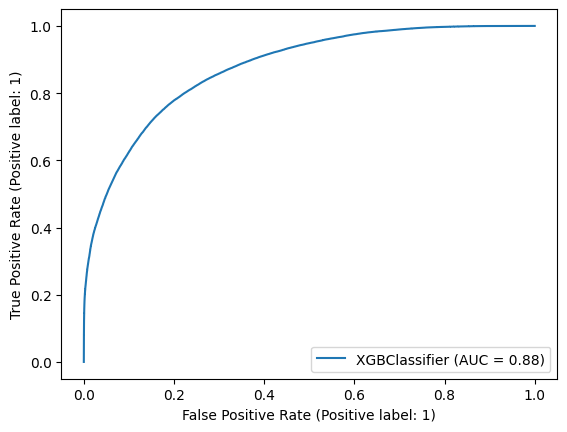

In [13]:
from sklearn.metrics import RocCurveDisplay

roc_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test)
task.logger.report_matplotlib_figure(
    title="ROC Curve", series="Testing", iteration=0, figure=clf_disp
)

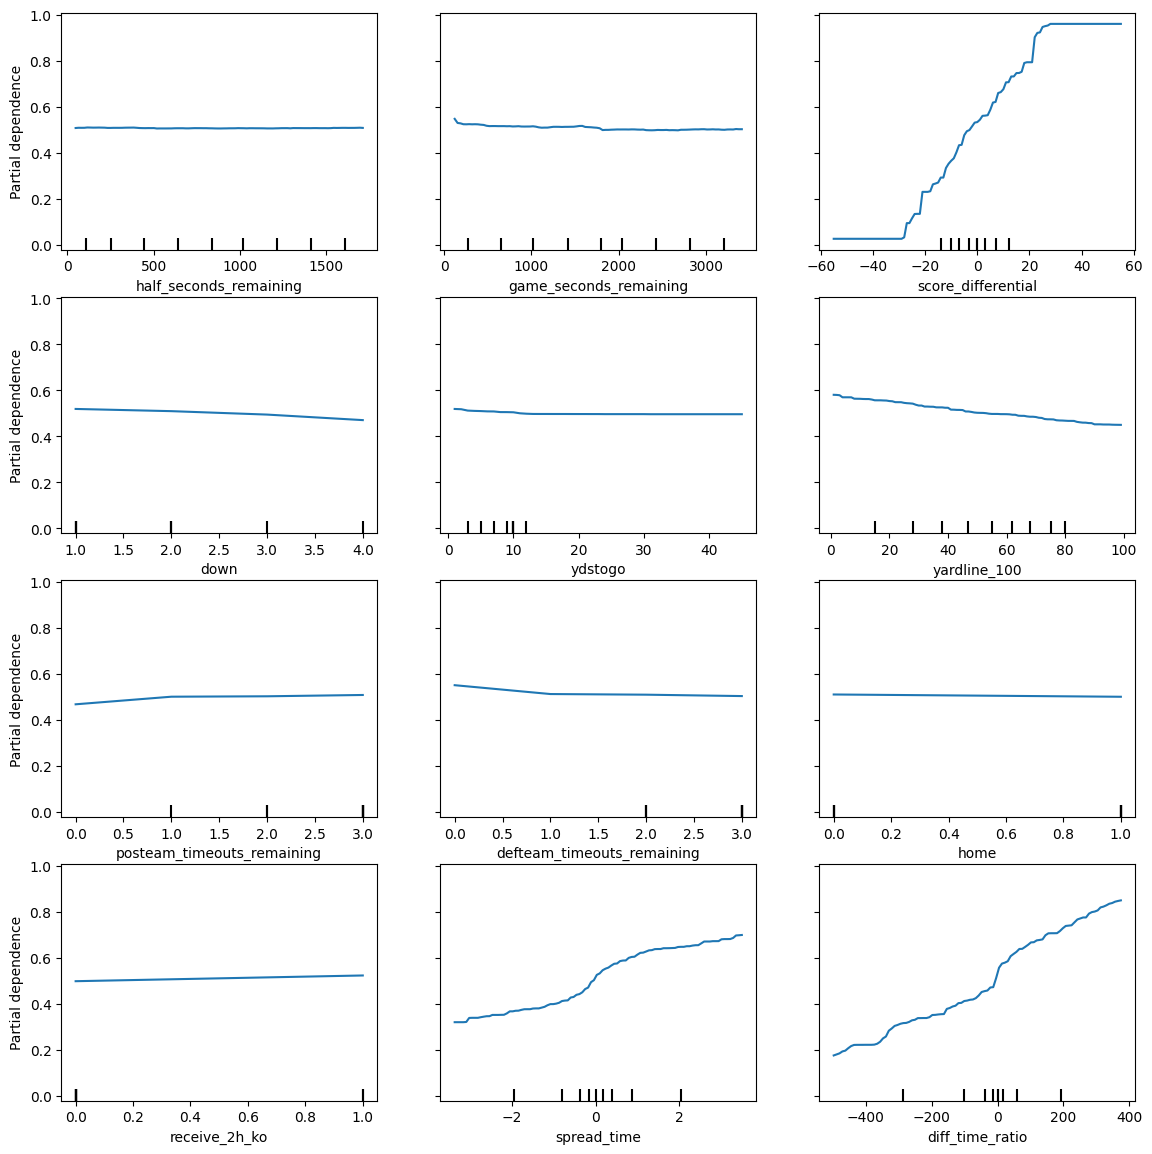

In [4]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))
fig.tight_layout(pad=3.0)
display = PartialDependenceDisplay.from_estimator(clf, X_test, features=X.columns, ax=ax)

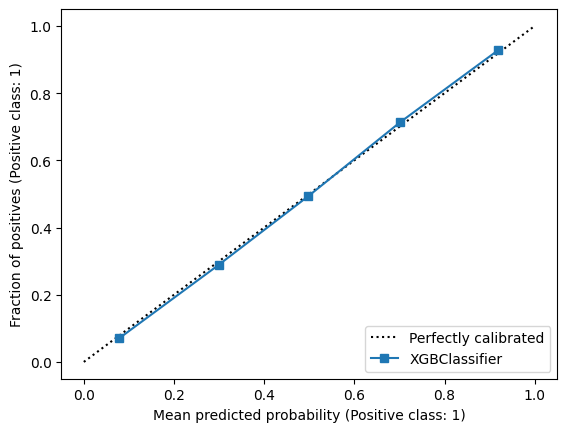

In [5]:
from sklearn.calibration import CalibrationDisplay
disp = CalibrationDisplay.from_estimator(clf, X_test, y_test)

In [11]:
import pickle
pickle.dump(clf, open('model.pkl', 'wb'))
output_model.set_upload_destination("s3://minio-test-s3.internal.magiccityit.com:443/test")
output_model.update_weights(weights_filename="model.pkl")
task.upload_artifact(name='model.pkl', artifact_object='model.pkl', auto_pickle=True, wait_on_upload=True)

2023-11-29 17:10:34,013 - clearml.storage - INFO - Starting upload: model.pkl => minio-test-s3.internal.magiccityit.com:443/test/NFL WP Model/WP Vegas Model.61f31230212e4275bc31767fd6782591/models/model.pkl
2023-11-29 17:10:34,087 - clearml.Task - INFO - Completed model upload to s3://minio-test-s3.internal.magiccityit.com:443/test/NFL WP Model/WP Vegas Model.61f31230212e4275bc31767fd6782591/models/model.pkl


True